# Problem Statement

I was provided with a High Quality RGB images with faces and my task was to segment out the eyes and lips regions in it.

# Importing required modules

In [0]:
# Installing required additional modules
!pip install tqdm
# Importing required modules
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.vis_utils import plot_model
from IPython.display import Image
from keras import backend as k
import keras
import matplotlib.pyplot as plt
from keras.initializers import *
import os
import cv2
import numpy as np
import pickle
import concurrent.futures
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


All the required training and preprocessing steps are inserted as functions into the class maskify. Detailed explanation of each function is provided as comments inside the function.

In [0]:
class maskify:
    def __init__(self, height=224, width=224, mask_channels=1, image_channels=3, epochs=5000, batch_size=64, chunk_size=5000, no_chunks=2, image_base_path="CelebAMask-HQ/CelebA-HQ-img/", ann_base_path="CelebAMask-HQ/CelebAMask-HQ-mask-anno/"):
        ''' This does all the necessary initialisations.
        Reasons:
        Height and Width: I wanted to reduce the image dimensions for easy computation. Ended up with 224*224 because I am using an inspired U-net model which involves downsampling and upsampling.
        Channels in mask image: I am considering a pixel wise mean squared error and hence to increase the performance, grayscale instead of RGB image would be a best fit.
        EPOCHS: My model converges really fast and hence 1000 epochs is sufficient for getting good results. I chose 5000 arbitrarly.
        BATCH_SIZE: Arbitrarly chose this value
        Chunk_size: Arbitrarly chosen value
        No_of_chunks: My model can learn with very few training samples.
        ''' 
        self.IN_HEIGHT = height 
        self.IN_WIDTH = width
        self.IN_CHANNELS_MASK = mask_channels
        self.IN_CHANNELS_IM = image_channels
        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size
        self.CHUNK_SIZE = chunk_size
        self.NO_OF_CHUNKS = no_chunks
        self.images = []
        self.masks = []
        self.image_base = image_base_path
        self.ann_base = ann_base_path

    def initial_steps(self):
        ''' Steps before actual training'''
        self.download_data()
        self.pre_process_masks()
        self.pre_process_images()
        self.load_images()
        self.load_masks()
        self.create_model()
        self.compile_model()

    def download_data(self):
        ''' Downloads the dataset from the drive and unzips it, if it is not done already.'''
        if(os.path.isdir("CelebAMask-HQ/")):
            return  
        !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1badu11NqxGf6qM3PTTooQDJvQbejgbTv' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1badu11NqxGf6qM3PTTooQDJvQbejgbTv" -O "dataset.zip" && rm -rf /tmp/cookies.txt
        !unzip -q dataset.zip
        !rm dataset.zip
        return
    
    def fuse_masks(self,u_lip, l_lip, r_eye, l_eye):
        ''' Takes upper_lip, lower_lip, right_eye, and left_eye masks and fuses them to create a single mask.'''
        # If any of the mask is absent, replaces it with a black mask
        if(u_lip is None):
            u_lip = np.zeros((512, 512), dtype = np.uint8)
        if(l_lip is None):
            l_lip = np.zeros((512, 512), dtype = np.uint8)
        if(r_eye is None):
            r_eye = np.zeros((512, 512), dtype = np.uint8)
        if(l_eye is None):
            l_eye = np.zeros((512, 512), dtype = np.uint8)
        
        lips = np.add(u_lip, l_lip) # fuses both the lip masks
        eyes = np.add(r_eye, l_eye) # fuses both the eye masks
        final_mask = np.add(lips, eyes) # fuses eyes and lips 
        return final_mask

    def pre_process_masks_helper(self, image):
        '''Opens all the four masks, passes them to the fuse_masks function and finally resizes the returned image to 224*224.'''
        temp = image.split('.')[0]
        folder_count = int(int(temp) / 2000) # determines the folder in which the masks are located.
        temp = temp.zfill(5) # pads the filename with zeros to the left.
        ann_u_lip_file = temp + "_u_lip.png"
        ann_l_lip_file = temp + "_l_lip.png"
        ann_l_eye_file = temp + "_l_eye.png"
        ann_r_eye_file = temp + "_r_eye.png"
        u_lip_img = cv2.imread(self.ann_base + str(folder_count) + "/" + ann_u_lip_file, cv2.IMREAD_GRAYSCALE)
        l_lip_img = cv2.imread(self.ann_base + str(folder_count) + "/" + ann_l_lip_file, cv2.IMREAD_GRAYSCALE)
        l_eye_img = cv2.imread(self.ann_base + str(folder_count) + "/" + ann_l_eye_file, cv2.IMREAD_GRAYSCALE)
        r_eye_img = cv2.imread(self.ann_base + str(folder_count) + "/" + ann_r_eye_file, cv2.IMREAD_GRAYSCALE)
        t = self.fuse_masks(u_lip_img, l_lip_img, r_eye_img, l_eye_img)
        del u_lip_img
        del l_lip_img
        del l_eye_img
        del r_eye_img
        t = cv2.resize(t, (self.IN_HEIGHT, self.IN_WIDTH))
        t = t.astype('float32')
        t = (t - 127.5) / 127.5 # converts the image in the range [-1, 1]
        return t

    def pre_process_masks(self):
        ''' This is a parallelised code, where the image list is shared among different cores of CPU for performing pre_process_masks_helper function'''
        images_list = os.listdir(self.image_base) # contains all the image file names
        images_list.sort()
        # Checks if numpy arrays are already created or not.
        if(os.path.exists('masks_0.npy')):
            return
        # iterates NO_OF_CHUNKS times on CHUNK_SIZE images
        for i in range(self.NO_OF_CHUNKS):
            masks = []
            image_list = images_list[self.CHUNK_SIZE*i : self.CHUNK_SIZE + self.CHUNK_SIZE*i]
            with concurrent.futures.ProcessPoolExecutor() as executor: # creates a process pooler 
                for image, mask in zip(image_list, executor.map(self.pre_process_masks_helper, image_list)): # shares the list among different cores of CPU
                    masks.append(mask)
                        
            masks = np.array(masks, dtype = np.float32)
            # Saves the masks numpy array on to the drive
            with open("masks_" + str(i) +".npy",'wb') as pickle_file:
                pickle.dump(masks,pickle_file,pickle.HIGHEST_PROTOCOL)
            print("Processed and saved " + str(self.CHUNK_SIZE + i*self.CHUNK_SIZE) + " images")
            del masks
        print("Masks saved successfully!")
    
    def resize_image(self, image):
        ''' Takes in an image, opens it, resizes it, and coverts it into the range [-1, 1]. '''
        t = cv2.imread(self.image_base + image)
        t = cv2.resize(t, (self.IN_HEIGHT, self.IN_WIDTH))
        t = (t - 127.5) / 127.5
        return t

    def pre_process_images(self):
        ''' This is a parallelised code, where the image list is shared among different cores of CPU for performing resize_image function'''
        images_list = os.listdir(self.image_base) # contains all the image file names
        images_list.sort()
        i = 0
        # Checks if numpy arrays are already created or not.
        if(os.path.exists('images_0.npy')):
            return
        # iterates NO_OF_CHUNKS times on CHUNK_SIZE images
        for i in range(self.NO_OF_CHUNKS):
            images = []
            image_list = images_list[self.CHUNK_SIZE*i : self.CHUNK_SIZE + self.CHUNK_SIZE*i]
            with concurrent.futures.ProcessPoolExecutor() as executor: # creates a process pooler   
                for image, mask in zip(image_list, executor.map(self.resize_image, image_list)): # shares the list among different cores of CPU
                    images.append(mask)

            images = np.array(images, dtype = np.float32)
            # Saves the images numpy array on to the drive
            with open("images_" + str(i) +".npy",'wb') as pickle_file:
                pickle.dump(images,pickle_file,pickle.HIGHEST_PROTOCOL)
            print("Processed and saved "+ str(self.CHUNK_SIZE + i*self.CHUNK_SIZE) + " images")
            del images
        print("Images saved successfully!")

    def load_images(self):
        ''' Loads the images saved on the drive as npy to the main memory.'''
        temp = []
        for i in range(self.NO_OF_CHUNKS):
            with open("images_" + str(i) +".npy",'rb') as pickle_file:
                imgs = pickle.load(pickle_file)
                temp.append(imgs)
                del imgs
        self.images = np.concatenate((temp[0], temp[1]), axis=0)
        print("Images Loaded successfully!")
    
    def load_masks(self):
        ''' Loads the masks saved on the drive as npy to the main memory.'''
        temp = []
        for i in range(self.NO_OF_CHUNKS):
            with open("masks_" + str(i) +".npy",'rb') as pickle_file:
                imgs = pickle.load(pickle_file)
                temp.append(imgs)
                del imgs
        self.masks = np.concatenate((temp[0], temp[1]), axis=0)
        self.masks = self.masks.reshape((self.NO_OF_CHUNKS*self.CHUNK_SIZE, self.IN_HEIGHT, self.IN_WIDTH, self.IN_CHANNELS_MASK))
        print("Masks loaded successfully!")

    def create_model(self):
        ''' Creates the U-net inspired model with input dimensions (224, 224, 3).'''
        input_size=(self.IN_HEIGHT, self.IN_WIDTH, self.IN_CHANNELS_IM)
        inputs = Input(input_size, name='image_input')
        init = RandomNormal(mean=0.0, stddev=0.02)
        conv1 = Conv2D(32, 3, strides = (2,2), padding='same', kernel_initializer=init, name='aen_conv1')(inputs)
        bn1 = BatchNormalization(momentum = 0.8)(conv1)
        lr1 = LeakyReLU(0.2)(bn1)
        
        conv2 = Conv2D(64, 3, strides = (2,2), padding='same', kernel_initializer=init, name='aen_conv2')(lr1)
        bn2 = BatchNormalization(momentum = 0.8)(conv2)
        lr2 = LeakyReLU(0.2)(bn2)
        
        conv3 = Conv2D(128 , 3, strides = (2,2), padding='same', kernel_initializer=init, name='aen_conv3')(lr2)
        bn3 = BatchNormalization(momentum = 0.8)(conv3)
        lr3 = LeakyReLU(0.2)(bn3)
        
        conv4 = Conv2D(256, 3, strides = (2,2), padding='same', kernel_initializer=init, name='aen_conv4')(lr3)
        bn4 = BatchNormalization(momentum = 0.8)(conv4)
        lr4 = LeakyReLU(0.2)(bn4)
        drop4 = Dropout(0.5)(lr4)

        conv5 = Conv2D(128, 3, padding = 'same', kernel_initializer = init, name = 'aen_conv5')(UpSampling2D(size=(2, 2))(drop4))
        bn5 = BatchNormalization(momentum = 0.8)(conv5)
        lr5 = LeakyReLU(0.2)(bn5)
        merge5 = concatenate([lr3, lr5], axis=3)
        conv6 = Conv2D(128, 3, padding='same', kernel_initializer=init, name='aen_conv6')(merge5)
        bn6 = BatchNormalization(momentum = 0.8)(conv6)
        lr6 = LeakyReLU(0.2)(bn6)

        conv7 = Conv2D(64, 3, padding = 'same', kernel_initializer = init, name ='aen_conv7') (UpSampling2D(size=(2, 2))(lr6))
        bn7 = BatchNormalization(momentum = 0.8)(conv7)
        lr7 = LeakyReLU(0.2)(bn7)
        merge6 = concatenate([lr2, lr7], axis=3)
        conv8 = Conv2D(64, 3, padding='same', kernel_initializer=init, name='aen_conv8')(merge6)
        bn8 = BatchNormalization(momentum = 0.8)(conv8)
        lr8 = LeakyReLU(0.2)(bn8)

        conv9 = Conv2D(32, 3, padding='same', kernel_initializer = init, name = 'aen_conv9') (UpSampling2D(size=(2, 2))(lr8))
        bn9 = BatchNormalization(momentum = 0.8)(conv9)
        lr9 = LeakyReLU(0.2)(bn9)
        merge7 = concatenate([lr1, lr9], axis=3)

        up11 = UpSampling2D(size=(2,2))(merge7)
        conv10 = Conv2D(1, 3, activation = 'tanh', padding='same', kernel_initializer= init, name='aen_out')(up11)

        model = Model(input=[inputs], output=[conv10] , name= 'autoencoder')
        return model
    
    def custom_loss(self, y_true, y_pred):
        ''' This is the custom_loss function which my model tries to optimise. It is the pixel-wise mean squared error''' 
        loss = k.mean(k.square(y_true - y_pred), axis=-1)
        return loss

    def compile_model(self):
        ''' Compiles the model with Adam optimizer, custom_loss as the loss function, and accuracy as metrics.'''
        self.aen = self.create_model()
        self.aen.compile(optimizer = Adam(lr=1e-4), loss=self.custom_loss, metrics = ['accuracy'] )
        print(self.aen.summary())
    
    def save_img(self, epoch):
        ''' Takes in the epoch, creates an image with our model prediction on 25 different images and saves it on the drive.'''
        i = np.random.randint(0,self.masks.shape[0],25) # selects 25 random image indices
        d_img = self.images[i] # select those 25 images
        g_img = self.aen.predict(d_img) # do prediction on those 25 images
        g_img = g_img * 0.5 + 0.5 # convert them into the range of [0,1]
        g_img = g_img*255 # convert them into the range of [0,255]
        g_img = g_img.astype(np.uint8)
        g_img = g_img.reshape((25, self.IN_HEIGHT, self.IN_WIDTH))
        fig, axs = plt.subplots(5,5, figsize=(25,25))
        for j in range(5):
            for k in range(5):
                axs[j,k].imshow(g_img[5*j + k])
                axs[j,k].axis('off')
        plt.show()
        fig.savefig("training_images/Faces_%d.png" % epoch) # Saves them on to the drive
        plt.close()
    
    def train(self):
        epochs = self.EPOCHS
        batch_size = self.BATCH_SIZE
        !mkdir training_images  
        for e in tqdm(range(epochs)):
            idx = np.random.randint(0, self.masks.shape[0], batch_size) # select batchsize number of images
            ground_truth = self.masks[idx]
            input_batch = self.images[idx]
            
            aen_loss = self.aen.train_on_batch(input_batch, ground_truth) # trains on the batch 
            print(aen_loss)
            
            # Visualise the performance after every 200 iterations
            if(e%200 == 0):
                self.save_img(e)
        
        self.aen.save('aen_model.h5') # Saves the model after training

    def thresholding(self, gen_img):
        ''' Binarizes the generated image to whites and blacks with 127 as threshold.'''
        gen_img = gen_img.reshape(self.IN_HEIGHT, self.IN_WIDTH)
        ret, thresh = cv2.threshold(gen_img,127,255,cv2.THRESH_BINARY_INV)
        return thresh

    def convert(self, gen_img):
        ''' Converts the binary one channel image to RGB image with blacks and whites alone.'''
        black = np.array([0,0,0], dtype = np.uint8)
        white = np.array([255,255,255], dtype = np.uint8)
        t = np.zeros((gen_img.shape[0], gen_img.shape[1], 3), dtype = np.uint8)
        for i in range(gen_img.shape[0]):
            for j in range(gen_img.shape[1]):
                if(gen_img[i][j] == 255):
                    t[i][j] = black
                if(gen_img[i][j] == 0):
                    t[i][j] = white
        return t

    def fix(self, image, aen):
        ''' Takes in an image, predicts the mask based on the model, binarizes the image and finally converts it into a RGB image.'''
        img = cv2.resize(image, (self.IN_HEIGHT, self.IN_WIDTH), interpolation = cv2.INTER_CUBIC)
        img = img.reshape(1, self.IN_HEIGHT, self.IN_WIDTH, self.IN_CHANNELS_IM)
        gen_img = aen.predict(img)
        gen_img = gen_img*0.5 + 0.5
        gen_img = gen_img*255
        gen_img = gen_img.astype(np.uint8)
        thresh = self.thresholding(gen_img)
        gen_img = self.convert(thresh)
        gen_img = gen_img.reshape(self.IN_HEIGHT, self.IN_WIDTH, self.IN_CHANNELS_IM)
        gen_img = cv2.resize(gen_img, (250, 250), interpolation = cv2.INTER_CUBIC)
        gen_img = gen_img.astype(np.uint8)
        return gen_img
    
    def visualise_results(self):
        ''' This function shows the model results after training. It takes 5 random images, predicts the RGB mask for it and overlays the mask on the original image.'''
        NUM_DISPLAY = 5
        images_list = os.listdir(self.image_base)
        images_list.sort()
        files = images_list[10000:]

        grid = []
        aen = load_model('aen_model.h5', custom_objects={'custom_loss': self.custom_loss})
        for path in random.sample(files, NUM_DISPLAY):
            im = self.resize_image(path)
            fixed = self.fix(im, aen)
            im = cv2.resize(im,(250,250))
            im = im*0.5 + 0.5
            im = im*255
            im = im.astype(np.uint8)
            final = cv2.addWeighted(im, 0.5, fixed, 0.5, 0.0)
            grid.append(np.column_stack([im, fixed, final]))

        # In the output image, the first column is the input image, the second column is the predicted mask of the image, 
        # and the third column is acquired after overlaying the mask on the image
        image = np.row_stack(grid)
        dpi = float(plt.rcParams['figure.dpi'])
        figsize = image.shape[1] / dpi, image.shape[0] / dpi
        ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
        ax.axis('off')
        ax.imshow(image[..., ::-1])
        plt.show()

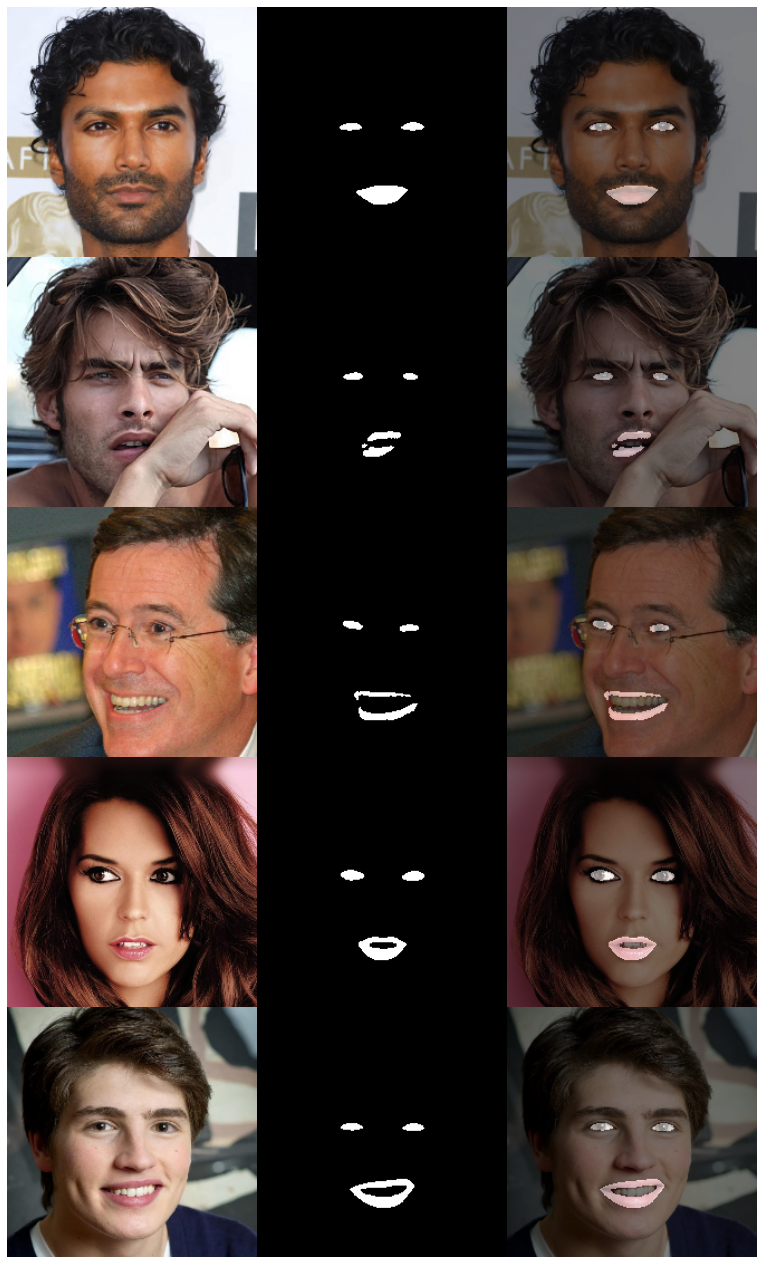

In [0]:
if __name__ == '__main__':
    m = maskify()
    m.initial_steps()
    m.train()
    # m.download_data()
    m.visualise_results()